<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/SER_CARINE/Paper_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import librosa
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATASET_PATH = "/content/drive/MyDrive/DeepLearning/External/EMoDB/"
OUTPUT_PATH = "processed_data_lightweight/"

# Your EMODB Mapping (from your snippet)
EMOTION_MAP = {
    'W': 0, # Angry
    'L': 1, # Boredom
    'E': 2, # Disgust
    'A': 3, # Anxiety/Fear
    'F': 4, # Happiness
    'T': 5, # Sadness
    'N': 6  # Neutral
}

# Paper Specs (Li et al. 2023)
SAMPLE_RATE = 16000
SEGMENT_DURATION = 3.0 # seconds
OVERLAP_DURATION = 1.6 # seconds
# Samples per segment: 3 * 16000 = 48,000
SEGMENT_SAMPLES = int(SAMPLE_RATE * SEGMENT_DURATION)
# Step size: (3 - 1.6) * 16000 = 22,400 samples
STEP_SAMPLES = int(SAMPLE_RATE * (SEGMENT_DURATION - OVERLAP_DURATION))

# MFCC Specs from Paper
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 26
TARGET_WIDTH = 94

# ==========================================
# 2. EXTRACTOR FUNCTION
# ==========================================
def get_mfcc_image(audio_segment, sr):
    """
    Converts a 3-second audio array into a (26, 94, 1) MFCC image.
    """
    # 1. Extract MFCC
    # Note: center=True (default) is usually needed to hit 94 frames for 48k samples
    mfcc = librosa.feature.mfcc(
        y=audio_segment,
        sr=sr,
        n_mfcc=N_MELS,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH
    )

    # 2. Strict Shape Enforcement (Force Width to 94)
    if mfcc.shape[1] > TARGET_WIDTH:
        mfcc = mfcc[:, :TARGET_WIDTH]
    elif mfcc.shape[1] < TARGET_WIDTH:
        padding = TARGET_WIDTH - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, padding)), 'constant')

    # 3. Add Channel Dimension: (26, 94) -> (26, 94, 1)
    return mfcc[..., np.newaxis]

# ==========================================
# 3. MAIN LOOP
# ==========================================
def process_emodb():
    X_list = []
    Y_list = []
    S_list = [] # Speaker IDs

    print(f"Scanning {DATASET_PATH}...")

    if not os.path.exists(DATASET_PATH):
        print("Error: Path not found.")
        return

    files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.wav')]

    for file_name in tqdm(files, desc="Processing EMODB"):
        file_path = os.path.join(DATASET_PATH, file_name)

        try:
            # --- PARSING INFO ---
            # Name: 03a01Fa.wav
            speaker_id = file_name[0:2]   # "03"
            emotion_code = file_name[5]   # "F"

            if emotion_code not in EMOTION_MAP:
                continue

            label = EMOTION_MAP[emotion_code]

            # --- LOAD AUDIO ---
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # --- SEGMENTATION LOGIC ---
            # We need to handle files shorter than 3s AND longer files
            segments = []

            if len(y) < SEGMENT_SAMPLES:
                # Case A: Short file -> Pad to 3s
                padding = SEGMENT_SAMPLES - len(y)
                y_padded = np.pad(y, (0, padding), 'constant')
                segments.append(y_padded)
            else:
                # Case B: Long file -> Sliding Window
                for start in range(0, len(y) - SEGMENT_SAMPLES + 1, STEP_SAMPLES):
                    end = start + SEGMENT_SAMPLES
                    segments.append(y[start:end])

                # Optional: Grab the very end if we missed a chunk
                if len(y) > SEGMENT_SAMPLES and (len(y) - SEGMENT_SAMPLES) % STEP_SAMPLES != 0:
                    segments.append(y[-SEGMENT_SAMPLES:])

            # --- EXTRACT FEATURES FOR ALL SEGMENTS ---
            for segment in segments:
                mfcc_img = get_mfcc_image(segment, sr)

                X_list.append(mfcc_img)
                Y_list.append(label)
                S_list.append(speaker_id) # Important: Repeat Speaker ID for every segment

        except Exception as e:
            print(f"Error in {file_name}: {e}")

    # ==========================================
    # 4. SAVE
    # ==========================================
    print("\nConverting to Numpy Arrays...")
    X = np.array(X_list)
    Y = np.array(Y_list)
    S = np.array(S_list)

    # Clean NaNs just in case
    X = np.nan_to_num(X, nan=0.0)

    print(f"Total Segments Generated: {X.shape[0]}")
    print(f"X Shape: {X.shape}") # Expect (N, 26, 94, 1)
    print(f"Y Shape: {Y.shape}")
    print(f"Speakers: {len(np.unique(S))}")

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    np.save(os.path.join(OUTPUT_PATH, "X_lightweight.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, "Y_lightweight.npy"), Y)
    np.save(os.path.join(OUTPUT_PATH, "S_lightweight.npy"), S)
    print(f"Saved to {OUTPUT_PATH}")

if __name__ == "__main__":
    process_emodb()

Scanning /content/drive/MyDrive/DeepLearning/External/EMoDB/...


Processing EMODB: 100%|██████████| 535/535 [00:16<00:00, 31.94it/s]



Converting to Numpy Arrays...
Total Segments Generated: 765
X Shape: (765, 26, 94, 1)
Y Shape: (765,)
Speakers: 10
Saved to processed_data_lightweight/


In [4]:
!zip -r processed_data_lightweight.zip processed_data_lightweight

  adding: processed_data_lightweight/ (stored 0%)
  adding: processed_data_lightweight/X_lightweight.npy (deflated 17%)
  adding: processed_data_lightweight/S_lightweight.npy (deflated 92%)
  adding: processed_data_lightweight/Y_lightweight.npy (deflated 90%)


In [2]:
!unzip -q processed_data_lightweight.zip -d ./

replace ./processed_data_lightweight/X_lightweight.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./processed_data_lightweight/S_lightweight.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./processed_data_lightweight/Y_lightweight.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, initializers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_PATH = "processed_data_lightweight/"
BATCH_SIZE = 32
EPOCHS = 70
LEARNING_RATE = 0.00001

# ==========================================
# 2. CUSTOM LAYERS & BLOCKS
# ==========================================

class AReLU(layers.Layer):
    """
    Attention-based Rectified Linear Unit.
    Paper: "A Lightweight Multi-Scale Model for SER" (Li et al. 2023)
    Formula: f(x) = ReLU(x) + Attention(x) * x
    """
    def __init__(self, alpha=0.9, beta=2.0, **kwargs):
        super(AReLU, self).__init__(**kwargs)
        self.alpha_init = alpha
        self.beta_init = beta

    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha', shape=(),
                                     initializer=tf.constant_initializer(self.alpha_init),
                                     trainable=True)
        self.beta = self.add_weight(name='beta', shape=(),
                                    initializer=tf.constant_initializer(self.beta_init),
                                    trainable=True)
        super(AReLU, self).build(input_shape)

    def call(self, inputs):
        # Standard ReLU part
        relu_x = tf.nn.relu(inputs)

        # Attention part (Negative side: clamped alpha * x)
        neg_scale = tf.clip_by_value(self.alpha, 0.01, 0.99)
        neg_part = neg_scale * inputs * tf.cast(inputs < 0, tf.float32)

        # Attention part (Positive side: sigmoid(beta) * x)
        pos_scale = tf.math.sigmoid(self.beta)
        pos_part = pos_scale * inputs * tf.cast(inputs >= 0, tf.float32)

        return relu_x + neg_part + pos_part

def A_Inception_Block(x, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pool):
    """
    Multi-scale feature extraction block using AReLU.
    Branch 1: 1x1
    Branch 2: 1x1 -> 3x3
    Branch 3: 1x1 -> 5x5
    Branch 4: MaxPool -> 1x1
    """
    # Branch 1
    b1 = layers.Conv2D(f_1x1, (1, 1), padding='same')(x)
    b1 = AReLU()(b1)

    # Branch 2
    b2 = layers.Conv2D(f_3x3_r, (1, 1), padding='same')(x)
    b2 = AReLU()(b2)
    b2 = layers.Conv2D(f_3x3, (3, 3), padding='same')(b2)
    b2 = AReLU()(b2)

    # Branch 3
    b3 = layers.Conv2D(f_5x5_r, (1, 1), padding='same')(x)
    b3 = AReLU()(b3)
    b3 = layers.Conv2D(f_5x5, (5, 5), padding='same')(b3)
    b3 = AReLU()(b3)

    # Branch 4
    b4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    b4 = layers.Conv2D(f_pool, (1, 1), padding='same')(b4)
    b4 = AReLU()(b4)

    # Concatenate filters
    output = layers.Concatenate(axis=-1)([b1, b2, b3, b4])
    return output

def MCA_Block(x, reduction=4):
    """Multi-scale Cepstral Attention (Channel Attention)"""
    channel_axis = -1
    filters = x.shape[channel_axis]

    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, filters))(avg_pool)

    fc1 = layers.Conv2D(filters // reduction, (1, 1), activation='relu')(avg_pool)
    fc2 = layers.Conv2D(filters, (1, 1), activation='sigmoid')(fc1)

    return layers.Multiply()([x, fc2])

def TCA_Block(x):
    """Temporal-Cepstral Attention (Spatial Attention)"""
    # Wrap tf.reduce_mean and tf.reduce_max in Lambda layers
    avg_pool = layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])

    attention = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, attention])

def build_lightweight_model(input_shape=(26, 94, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # 1. Initial Conv
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = AReLU()(x)

    # 2. A_Inception Block 1
    # Configs from Table 2: (8, 12, 16, 2, 4, 4)
    x = A_Inception_Block(x, 8, 12, 16, 2, 4, 4)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # 3. A_Inception Block 2
    # Configs from Table 2: (16, 24, 32, 4, 8, 8)
    x = A_Inception_Block(x, 16, 24, 32, 4, 8, 8)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # 4. Deep Conv (to increase depth before GRU)
    x = layers.Conv2D(128, (5, 5), padding='same')(x)
    x = AReLU()(x)

    # 5. Attention (MCA-TCA)
    x = MCA_Block(x)
    x = TCA_Block(x)

    # 6. Temporal Modeling (GRU)
    # Reshape: (Batch, Freq, Time, Channels) -> (Batch, Time, Freq*Channels)
    # We need to preserve the Time axis (Width = 94)
    # Current Shape: (Batch, 7, 24, 128) roughly after pooling
    target_time = x.shape[2]
    target_feat = x.shape[1] * x.shape[3]
    x = layers.Reshape((target_time, target_feat))(x)

    x = layers.GRU(128, return_sequences=False)(x)

    # 7. Classification Head
    embedding = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(embedding)

    return models.Model(inputs, outputs, name="Lightweight_SER")

# ==========================================
# 3. DATA LOADING & PREPROCESSING
# ==========================================

def load_and_prep_data(split_type='random'):
    print("Loading data...")
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Path {DATA_PATH} not found.")

    X = np.load(os.path.join(DATA_PATH, "X_lightweight.npy"))
    Y = np.load(os.path.join(DATA_PATH, "Y_lightweight.npy"))
    S = np.load(os.path.join(DATA_PATH, "S_lightweight.npy"))

    X = np.nan_to_num(X, nan=0.0)

    # Standardization
    N, H, W, C = X.shape
    X_flat = X.reshape(N, -1)
    scaler = StandardScaler()

    if split_type == 'random':
        print("Splitting: Random 80/20")
        X_train, X_test, Y_train, Y_test = train_test_split(
            X_flat, Y, test_size=0.20, random_state=42, stratify=Y
        )
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    elif split_type == 'speaker':
        print("Splitting: Strict Speaker Independent")
        speakers = np.unique(S)
        split_idx = int(len(speakers) * 0.8)
        train_spks = speakers[:split_idx]
        test_spks = speakers[split_idx:]

        print(f"Training Speakers ({len(train_spks)}): {train_spks}")
        print(f"Testing Speakers ({len(test_spks)}): {test_spks}")

        train_mask = np.isin(S, train_spks)
        test_mask = np.isin(S, test_spks)

        X_train, Y_train = X_flat[train_mask], Y[train_mask]
        X_test, Y_test = X_flat[test_mask], Y[test_mask]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Reshape back
    X_train = X_train.reshape(-1, H, W, C)
    X_test = X_test.reshape(-1, H, W, C)

    return X_train, X_test, Y_train, Y_test

# ==========================================
# 4. MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    # Choose Split Type: 'random' (Verify Replication) OR 'speaker' (Test Hypothesis)
    SPLIT_TYPE = 'random'

    X_train, X_test, Y_train, Y_test = load_and_prep_data(SPLIT_TYPE)

    print(f"Train Shape: {X_train.shape}")
    print(f"Test Shape: {X_test.shape}")

    num_classes = len(np.unique(Y_train))

    # Build & Compile
    model = build_lightweight_model(input_shape=X_train.shape[1:], num_classes=num_classes)
    model.summary()

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    lr_schedule = callbacks.ReduceLROnPlateau(factor=0.95, patience=3, verbose=1)


Loading data...
Splitting: Random 80/20
Train Shape: (612, 26, 94, 1)
Test Shape: (153, 26, 94, 1)


Model: "Lightweight_SER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 26, 94, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 26, 94,    │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_14 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_17[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 26, 94,    │        204 │ a_re_lu_14[0][0]  │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 26, 94, 2) │         34 │ a_re_lu_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_16 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_19[0][0]   │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_18 (AReLU)  │ (None, 26, 94, 2) │          2 │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 26, 94,    │          0 │ a_re_lu_14[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 26, 94, 8) │        136 │ a_re_lu_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 26, 94,    │      1,744 │ a_re_lu_16[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 26, 94, 4) │        204 │ a_re_lu_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 26, 94, 4) │         68 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_15 (AReLU)  │ (None, 26, 94, 8) │          2 │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_17 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_20[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_19 (AReLU)  │ (None, 26, 94, 4) │          2 │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_20 (AReLU)  │ (None, 26, 94, 4) │          2 │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 26, 94,    │          0 │ a_re_lu_15[0][0], │
│ (Concatenate)       │ 32)               │            │ a_re_lu_17[0][0], │
│                     │                   │            │ a_re_lu_19[0][0], │
│                     │                   │            │ a_re_lu_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 13, 47,    │          0 │ concatenate_3[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 13, 47,    │        792 │ max_pooling2d_5[

 Total params: 628,040 (2.40 MB)

 Trainable params: 628,040 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Loading data...
Splitting: Random 80/20
Train Shape: (612, 26, 94, 1)
Test Shape: (153, 26, 94, 1)


Model: "Lightweight_SER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 26, 94, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 26, 94,    │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_42 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_50[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 26, 94,    │        204 │ a_re_lu_42[0][0]  │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 26, 94, 2) │         34 │ a_re_lu_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_44 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_52[0][0]   │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_46 (AReLU)  │ (None, 26, 94, 2) │          2 │ conv2d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 26, 94,    │          0 │ a_re_lu_42[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 26, 94, 8) │        136 │ a_re_lu_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 26, 94,    │      1,744 │ a_re_lu_44[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 26, 94, 4) │        204 │ a_re_lu_46[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 26, 94, 4) │         68 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_43 (AReLU)  │ (None, 26, 94, 8) │          2 │ conv2d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_45 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_53[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_47 (AReLU)  │ (None, 26, 94, 4) │          2 │ conv2d_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_48 (AReLU)  │ (None, 26, 94, 4) │          2 │ conv2d_56[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 26, 94,    │          0 │ a_re_lu_43[0][0], │
│ (Concatenate)       │ 32)               │            │ a_re_lu_45[0][0], │
│                     │                   │            │ a_re_lu_47[0][0], │
│                     │                   │            │ a_re_lu_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 13, 47,    │          0 │ concatenate_7[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 13, 47,    │        792 │ max_pooling2d_13

 Total params: 628,040 (2.40 MB)

 Trainable params: 628,040 (2.40 MB)

 Non-trainable params: 0 (0.00 B)


Starting Training...
Epoch 1/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.2417 - loss: 1.9521 - val_accuracy: 0.3464 - val_loss: 1.7242 - learning_rate: 0.0010
Epoch 2/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3539 - loss: 1.6736 - val_accuracy: 0.4575 - val_loss: 1.4873 - learning_rate: 0.0010
Epoch 3/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4659 - loss: 1.4186 - val_accuracy: 0.4248 - val_loss: 1.3999 - learning_rate: 0.0010
Epoch 4/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4957 - loss: 1.3111 - val_accuracy: 0.4641 - val_loss: 1.3980 - learning_rate: 0.0010
Epoch 5/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5595 - loss: 1.2370 - val_accuracy: 0.5098 - val_loss: 1.3355 - learning_rate: 0.0010
Epoch 6/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5985 - loss: 1.0317 - val_accuracy: 0.4837 - val_loss: 1.3754 - learning_rate: 0.0010
Epoch 7/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5726 

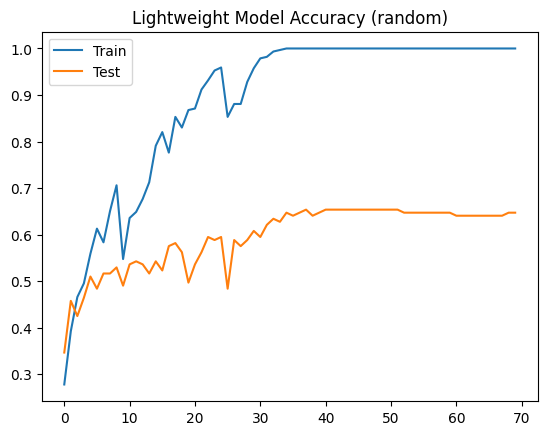

In [7]:
if __name__ == "__main__":
    # Choose Split Type: 'random' (Verify Replication) OR 'speaker' (Test Hypothesis)
    SPLIT_TYPE = 'random'

    X_train, X_test, Y_train, Y_test = load_and_prep_data(SPLIT_TYPE)

    print(f"Train Shape: {X_train.shape}")
    print(f"Test Shape: {X_test.shape}")

    num_classes = len(np.unique(Y_train))

    # Build & Compile
    model = build_lightweight_model(input_shape=X_train.shape[1:], num_classes=num_classes)
    model.summary()

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    lr_schedule = callbacks.ReduceLROnPlateau(factor=0.95, patience=3, verbose=1)

    print("\nStarting Training...")
    history = model.fit(
        X_train, Y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, Y_test),
        callbacks=[lr_schedule],
        verbose=1
    )

    # Evaluate
    loss, acc = model.evaluate(X_test, Y_test)
    print("\n------------------------------------------------")
    print(f"FINAL RESULT ({SPLIT_TYPE} split)")
    print(f"Accuracy: {acc*100:.2f}%")
    print("------------------------------------------------")

    # Plot
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title(f"Lightweight Model Accuracy ({SPLIT_TYPE})")
    plt.legend()
    plt.show()

Loading data...
Splitting: Strict Speaker Independent
Training Speakers (8): ['03' '08' '09' '10' '11' '12' '13' '14']
Testing Speakers (2): ['15' '16']
Train Shape: (585, 26, 94, 1)
Test Shape: (180, 26, 94, 1)


Model: "Lightweight_SER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 26, 94, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 26, 94,    │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_28 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_34[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 26, 94,    │        204 │ a_re_lu_28[0][0]  │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 26, 94, 2) │         34 │ a_re_lu_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_30 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_36[0][0]   │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_32 (AReLU)  │ (None, 26, 94, 2) │          2 │ conv2d_38[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 26, 94,    │          0 │ a_re_lu_28[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 26, 94, 8) │        136 │ a_re_lu_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 26, 94,    │      1,744 │ a_re_lu_30[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 26, 94, 4) │        204 │ a_re_lu_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 26, 94, 4) │         68 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_29 (AReLU)  │ (None, 26, 94, 8) │          2 │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_31 (AReLU)  │ (None, 26, 94,    │          2 │ conv2d_37[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_33 (AReLU)  │ (None, 26, 94, 4) │          2 │ conv2d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_re_lu_34 (AReLU)  │ (None, 26, 94, 4) │          2 │ conv2d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 26, 94,    │          0 │ a_re_lu_29[0][0], │
│ (Concatenate)       │ 32)               │            │ a_re_lu_31[0][0], │
│                     │                   │            │ a_re_lu_33[0][0], │
│                     │                   │            │ a_re_lu_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 13, 47,    │          0 │ concatenate_6[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 13, 47,    │        792 │ max_pooling2d_9[

 Total params: 628,040 (2.40 MB)

 Trainable params: 628,040 (2.40 MB)

 Non-trainable params: 0 (0.00 B)


Starting Training...
Epoch 1/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.0889 - loss: 1.9573 - val_accuracy: 0.1056 - val_loss: 1.9434 - learning_rate: 1.0000e-05
Epoch 2/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0970 - loss: 1.9363 - val_accuracy: 0.1500 - val_loss: 1.9352 - learning_rate: 1.0000e-05
Epoch 3/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1967 - loss: 1.9071 - val_accuracy: 0.1611 - val_loss: 1.9215 - learning_rate: 1.0000e-05
Epoch 4/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2229 - loss: 1.8669 - val_accuracy: 0.1556 - val_loss: 1.9046 - learning_rate: 1.0000e-05
Epoch 5/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2095 - loss: 1.8452 - val_accuracy: 0.1611 - val_loss: 1.8865 - learning_rate: 1.0000e-05
Epoch 6/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1971 - loss: 1.8338 - val_accuracy: 0.1611 - val_loss: 1.8700 - learning_rate: 1.0000e-05
Epoch 7/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/

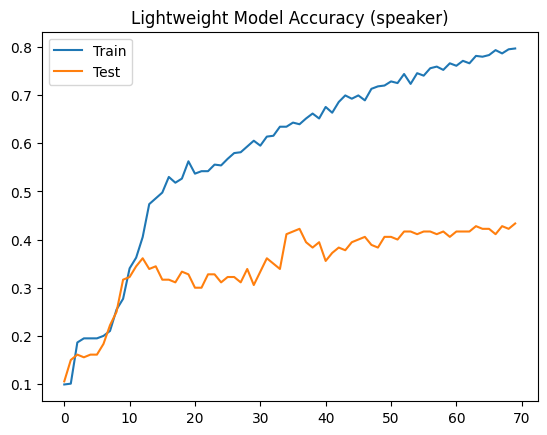

In [4]:
if __name__ == "__main__":
    # Choose Split Type: 'random' (Verify Replication) OR 'speaker' (Test Hypothesis)
    SPLIT_TYPE = 'speaker'

    X_train, X_test, Y_train, Y_test = load_and_prep_data(SPLIT_TYPE)

    print(f"Train Shape: {X_train.shape}")
    print(f"Test Shape: {X_test.shape}")

    num_classes = len(np.unique(Y_train))

    # Build & Compile
    model = build_lightweight_model(input_shape=X_train.shape[1:], num_classes=num_classes)
    model.summary()

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    lr_schedule = callbacks.ReduceLROnPlateau(factor=0.95, patience=3, verbose=1)

    print("\nStarting Training...")
    history = model.fit(
        X_train, Y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, Y_test),
        callbacks=[lr_schedule],
        verbose=1
    )

    # Evaluate
    loss, acc = model.evaluate(X_test, Y_test)
    print("\n------------------------------------------------")
    print(f"FINAL RESULT ({SPLIT_TYPE} split)")
    print(f"Accuracy: {acc*100:.2f}%")
    print("------------------------------------------------")

    # Plot
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title(f"Lightweight Model Accuracy ({SPLIT_TYPE})")
    plt.legend()
    plt.show()